In [1]:
#importing Required Libraries to run code
import glob
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.feature import hog

import warnings
warnings.filterwarnings('ignore')

# Data Preparation

In [2]:
def data_prep(path):
    vehicles_images = []
    
    for image_path in glob.glob(path + '/OwnCollection/vehicles/*/*.png'):
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        vehicles_images.append(image_rgb)

    non_vehicles_images = []
    for imagePath in glob.glob(path + '/OwnCollection/non-vehicles/*/*.png'):
        image =cv2.imread(imagePath)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        non_vehicles_images.append(image_rgb)

    print("Number of Vehicle Images:", len(vehicles_images))
    print("Number of Non-Vehicle Images:", len(non_vehicles_images))
    
    return vehicles_images, non_vehicles_images

In [3]:
path = "C://Users//Nando's Lenovo//Desktop//Python_Projects//Car_Detection_CV"
vehicles_images, non_vehicles_images = data_prep(path)
print("Total images in dataset:", len(vehicles_images)+len(non_vehicles_images))

Number of Vehicle Images: 3425
Number of Non-Vehicle Images: 3900
Total images in dataset: 7325


In [4]:
def visualize(image,hog_img,hog_viz=False):
    if hog_viz:
        f, axes= plt.subplots(1,2,figsize=(8,8))
        axes[0].imshow(image)
        axes[1].imshow(hog_img)
    else:
        f, axes = plt.subplots(2,2, figsize=(8,8))
        plt.subplots_adjust(hspace=0.5)

        for index in range(2):
            vehicles = np.random.randint(0, len(vehicles_images)-1)
            non_vehicles = np.random.randint(0, len(vehicles_images)-1)
            axes[index,0].imshow(vehicles_images[vehicles])
            axes[index,0].set_title("Vehicle")
            axes[index,1].imshow(non_vehicles_images[non_vehicles])
            axes[index,1].set_title("Non vehicles")
        print("Car Image Shape:", vehicles_images[vehicles].shape)
        print("Non Car Image Shape", non_vehicles_images[non_vehicles].shape)

Car Image Shape: (64, 64, 3)
Non Car Image Shape (64, 64, 3)


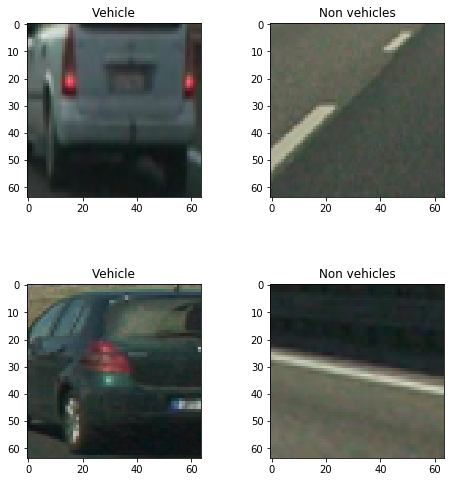

In [5]:
visualize(None,None,hog_viz=False)

# HOG (Histogram of Oriented Gradients) for Extracting Features

In [6]:
def extract_hog_features(image,orient,cellsPerBlock,pixelsPerCell, visualise= False, feature_vector_flag=True):
    if(visualise==True):
        hog_features, hog_image = hog(image, orientations=orient,
                          pixels_per_cell=(pixelsPerCell, pixelsPerCell), 
                          cells_per_block=(cellsPerBlock, cellsPerBlock), 
                          visualise=True, feature_vector=feature_vector_flag)
        return hog_features, hog_image
    else:
        hog_features = hog(image, orientations=orient,
                          pixels_per_cell=(pixelsPerCell, pixelsPerCell), 
                          cells_per_block=(cellsPerBlock, cellsPerBlock), 
                          visualise=False, feature_vector=feature_vector_flag)
        return hog_features

Feature Vector Length Returned is: 324
No of features that can be extracted from image: 4096


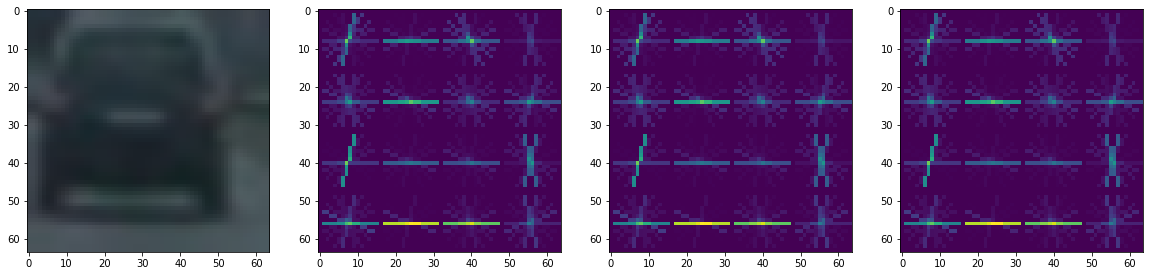

In [7]:
image = vehicles_images[50]
image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
image_channel_0 = image[:,:,0]
image_channel_1 = image[:,:,0]
image_channel_2 = image[:,:,0]

feature_0,hog_img_0 = extract_hog_features(image_channel_0,9,2,16,visualise=True,feature_vector_flag=True)
feature_1,hog_img_1 = extract_hog_features(image_channel_1,9,2,16,visualise=True,feature_vector_flag=True)
feature_2,hog_img_2 = extract_hog_features(image_channel_2,9,2,16,visualise=True,feature_vector_flag=True)

f, axes = plt.subplots(1,4,figsize=(20,10))
axes[0].imshow(vehicles_images[50])
axes[1].imshow(hog_img_0)
axes[2].imshow(hog_img_1)
axes[3].imshow(hog_img_2)


print("Feature Vector Length Returned is:", len(feature_0))
print("No of features that can be extracted from image:", len(hog_img_0.ravel()))

In [8]:
"""def rgb_to_yuv(image, colorspace):
    return cv2.cvtColor(image, colorspace)"""

'def rgb_to_yuv(image, colorspace):\n    return cv2.cvtColor(image, colorspace)'

In [9]:
def extract_features(images,orientation,cellsPerBlock,pixelsPerCell, convertColorspace=False):
    feature_list = []
    
    for image in images:
        if(convertColorspace==True):
            image= cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        local_features_1 = extract_hog_features(image[:,:,0],orientation,cellsPerBlock,pixelsPerCell, False, True)
        local_features_2 = extract_hog_features(image[:,:,1],orientation,cellsPerBlock,pixelsPerCell, False, True)
        local_features_3 = extract_hog_features(image[:,:,2],orientation,cellsPerBlock,pixelsPerCell, False, True)
        x = np.hstack((local_features_1,local_features_2,local_features_3))
        feature_list.append(x)
    return feature_list

In [10]:
orientations = 9
cellsPerBlock = 2
pixelsPerBlock = 16
convertColorSpace = True

vehicle_features = extract_features(vehicles_images,orientations,cellsPerBlock,pixelsPerBlock, convertColorSpace)
non_vehicle_features = extract_features(non_vehicles_images,orientations,cellsPerBlock,pixelsPerBlock, convertColorSpace)


In [11]:
X = np.vstack([vehicle_features, non_vehicle_features])
print("Shape of features list is:", X.shape)
y = np.concatenate([np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))])
print("Shape of label list is:", y.shape)

Shape of features list is: (7325, 972)
Shape of label list is: (7325,)


# Splitting Data into Training and Test Set

In [12]:
from sklearn.model_selection import train_test_split
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# Define and Train a classifier

In [13]:
from sklearn.svm import SVC

svc_calssifier = SVC(kernel='rbf', C = 0.8, gamma = "auto")
svc_calssifier.fit(X_train, y_train)
print("Accuracy of SVC is:", svc_calssifier.score(X_test, y_test) )

Accuracy of SVC is: 0.9467576791808874


# Sliding Window

In [14]:
import matplotlib.image as mpimg

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    
    imcopy = np.copy(img)
    
    for bbox in bboxes:
        r=random.randint(0,255)
        g=random.randint(0,255)
        b=random.randint(0,255)
        color=(r, g, b)
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [15]:
def slide_window(img, x_start_stop = [None, None], y_start_stop = [None, None], 
                    xy_window = (64, 64), xy_overlap = (0.9, 0.9)):
   
    if x_start_stop[0] == None:
        x_start_stop[0]=0
    if x_start_stop[1] == None:
        x_start_stop[1]=img.shape[1]
    if y_start_stop[0] ==  None:
        y_start_stop[0]= 0
    if y_start_stop[1] ==  None:
        y_start_stop[1]=img.shape[0]
    
    window_list = []
    image_width_x = x_start_stop[1] - x_start_stop[0]
    image_width_y = y_start_stop[1] - y_start_stop[0]
     
    windows_x = np.int(1 + (image_width_x - xy_window[0])/(xy_window[0] * xy_overlap[0]))
    windows_y = np.int(1 + (image_width_y - xy_window[1])/(xy_window[1] * xy_overlap[1]))
    
    modified_window_size = xy_window
    
    for i in range(windows_y):
        y_start = y_start_stop[0] + np.int(i*modified_window_size[1]*xy_overlap[1])
        for j in range(windows_x):
            x_start = x_start_stop[0] + np.int(j*modified_window_size[0]*xy_overlap[0])
            
            endx = np.int(x_start + modified_window_size[0])
            endy = np.int(y_start + modified_window_size[1])
            window_list.append(((x_start,y_start),(endx,endy)))
    return window_list

In [16]:
def detect_vehicles(image,windows, converColorspace=False):
    refinedWindows = []
    for window in windows:
        
        start = window[0]
        end = window[1]
        clippedImage = image[start[1]:end[1], start[0]:end[0]]
        
        if(clippedImage.shape[1] == clippedImage.shape[0] and clippedImage.shape[1]!=0):
            
            clippedImage = cv2.resize(clippedImage, (64,64))
            
            f1 = extract_features([clippedImage], 9 , 2 , 16,converColorspace)
        
            predictedOutput = svc_calssifier.predict([f1[0]])
            if(predictedOutput == 1):
                refinedWindows.append(window)
        
    return refinedWindows

Total No of windows are  470


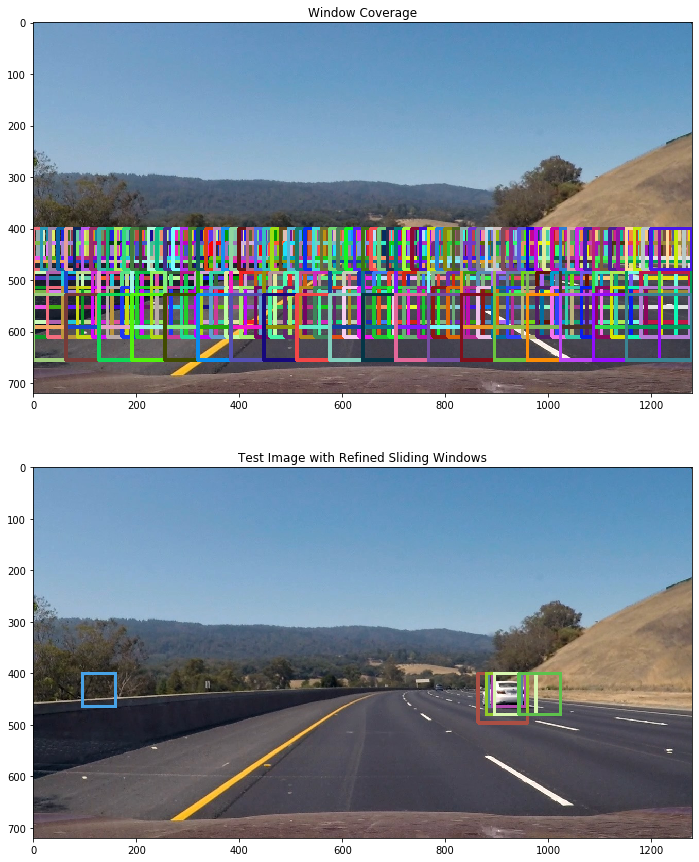

In [17]:
from PIL import Image
image = np.array(Image.open('test3.jpg'))

windows1 = slide_window(image, x_start_stop = [0, 1280], y_start_stop = [400,464], 
                    xy_window = (64,64), xy_overlap = (0.15, 0.15))
windows4 = slide_window(image, x_start_stop = [0, 1280], y_start_stop = [400,480], 
                    xy_window = (80,80), xy_overlap = (0.2, 0.2))
windows2 = slide_window(image, x_start_stop = [0, 1280], y_start_stop = [400,612], 
                    xy_window = (96,96), xy_overlap = (0.3, 0.3))
windows3 = slide_window(image, x_start_stop = [0, 1280], y_start_stop = [400,660], 
                    xy_window = (128,128), xy_overlap = (0.5, 0.5))


windows = windows1 + windows2 + windows3 + windows4
print("Total No of windows are ",len(windows))
refinedWindows = detect_vehicles(image,windows, True)



f,axes = plt.subplots(2,1, figsize=(30,15))

window_img = draw_boxes(image, windows) 

axes[0].imshow(window_img)
axes[0].set_title("Window Coverage")

window_img = draw_boxes(image, refinedWindows) 

axes[1].set_title("Test Image with Refined Sliding Windows")
axes[1].imshow(window_img)

# Applying Heatmap 

In [18]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap 

In [19]:
def apply_threshold(heatmap, threshold):
    
    heatmap[heatmap <= threshold] = 0

    return heatmap

In [20]:
from scipy.ndimage.measurements import label

def draw_labeled_bboxes(img, labels):

    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

Number of Cars found: 1


Text(0.5, 1.0, 'Final Image after applying Heat Map')

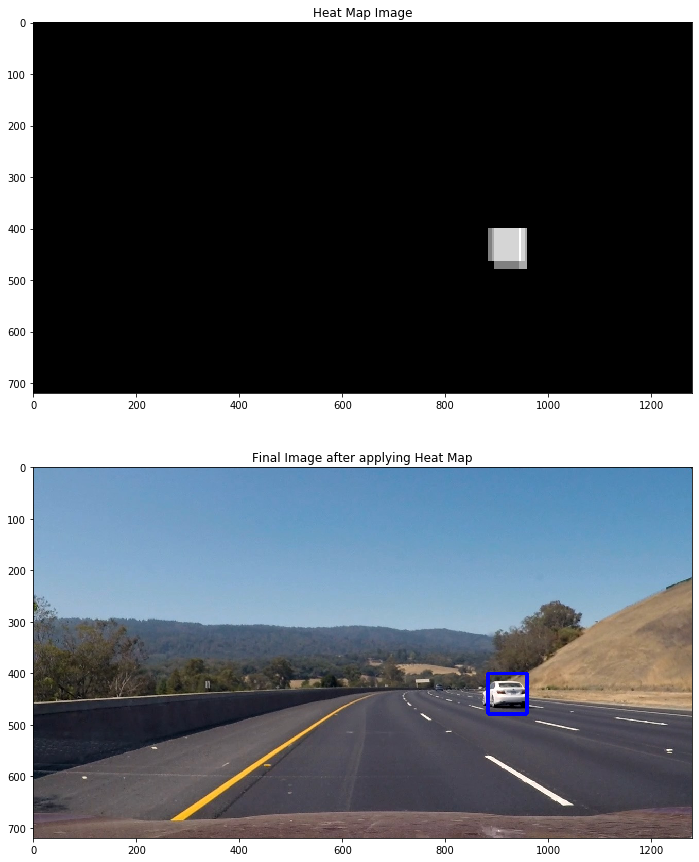

In [21]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

heat = add_heat(heat, refinedWindows)
    
heat = apply_threshold(heat,2)

heatmap = np.clip(heat, 0, 255)

heat_image = heatmap

labels = label(heatmap)
print("Number of Cars found:", labels[1])
draw_img = draw_labeled_bboxes(np.copy(image), labels)

f,axes= plt.subplots(2,1, figsize=(30,15))
axes[0].imshow(heat_image,cmap='gray')
axes[0].set_title("Heat Map Image")
axes[1].imshow(draw_img)
axes[1].set_title("Final Image after applying Heat Map")

# Averaging Rectangles over Frames

In [22]:
class Averaging():
    def __init__(self):
        self.refinedWindows = [] 
        
    def Add_Windows(self, refinedWindow):
        self.refinedWindows.append(refinedWindow)
        frameHistory= 25
        if len(self.refinedWindows) > frameHistory:
            self.refinedWindows = self.refinedWindows[len(self.refinedWindows)-frameHistory:]

# Defining Pipeline

In [23]:
orientation = 9 
cellsPerBlock = 2 
pixelsPerCell = 16 
xy_window = (64, 64) 
xy_overlap = (0.15, 0.15) 
x_start_stop = [0, image.shape[1]] 
y_start_stop = [400, 660] 

# Window 1- Size - 64x64 , Overlap-85%
windows_normal = slide_window(image, x_start_stop, [400,464], 
                    xy_window, xy_overlap)

# Window 2- Size - 80x80 , Overlap-80%
xy_window_1_25= (80,80)
xy_window_1_25_overlap=(0.2, 0.2)    
windows_1_25 = slide_window(image, x_start_stop, [400,480], 
                    xy_window_1_25, xy_window_1_25_overlap)

# Window 3- Size - 96x96 , Overlap-70%
xy_window_1_5= (96,96)
xy_window_1_5_overlap=(0.3, 0.3)    
windows_1_5 = slide_window(image, x_start_stop, [400,612], 
                    xy_window_1_5, xy_window_1_5_overlap)

# Window 4- Size - 128x128 , Overlap-50%
xy_window_twice_overlap=(0.5, 0.5)    
xy_window_twice = (128,128)
windows_twice = slide_window(image, x_start_stop, [400,660], 
                    xy_window_twice, xy_window_twice_overlap)

# Total Windows
windows= windows_normal +  windows_1_5  + windows_twice +windows_1_25
print("No of Windows are:",len(windows))

No of Windows are: 470


In [24]:
def video_pipeline(image):
    
    rand = random.randint(0,1)
    if (rand < 0.2):
        refinedWindows = averaging_windows.refinedWindows[:-1]
    else:
        refinedWindows = detect_vehicles(image,windows,True)
        if len(refinedWindows) > 0:
            averaging_windows.Add_Windows(refinedWindows)
            
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    for refinedWindow in averaging_windows.refinedWindows:
        heat = add_heat(heat, refinedWindow)
    
    
    
    heatmap = apply_threshold(heat, 2+len(averaging_windows.refinedWindows)//2)
    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

In [25]:
def image_pipeline(image):

    refinedWindows = detect_vehicles(image,windows, True)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,refinedWindows)
   
    heatmap = np.clip(heat, 0, 255)
    heatmap = apply_threshold(heat, 2)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img, heatmap

# Testing Pipeline on Test Images

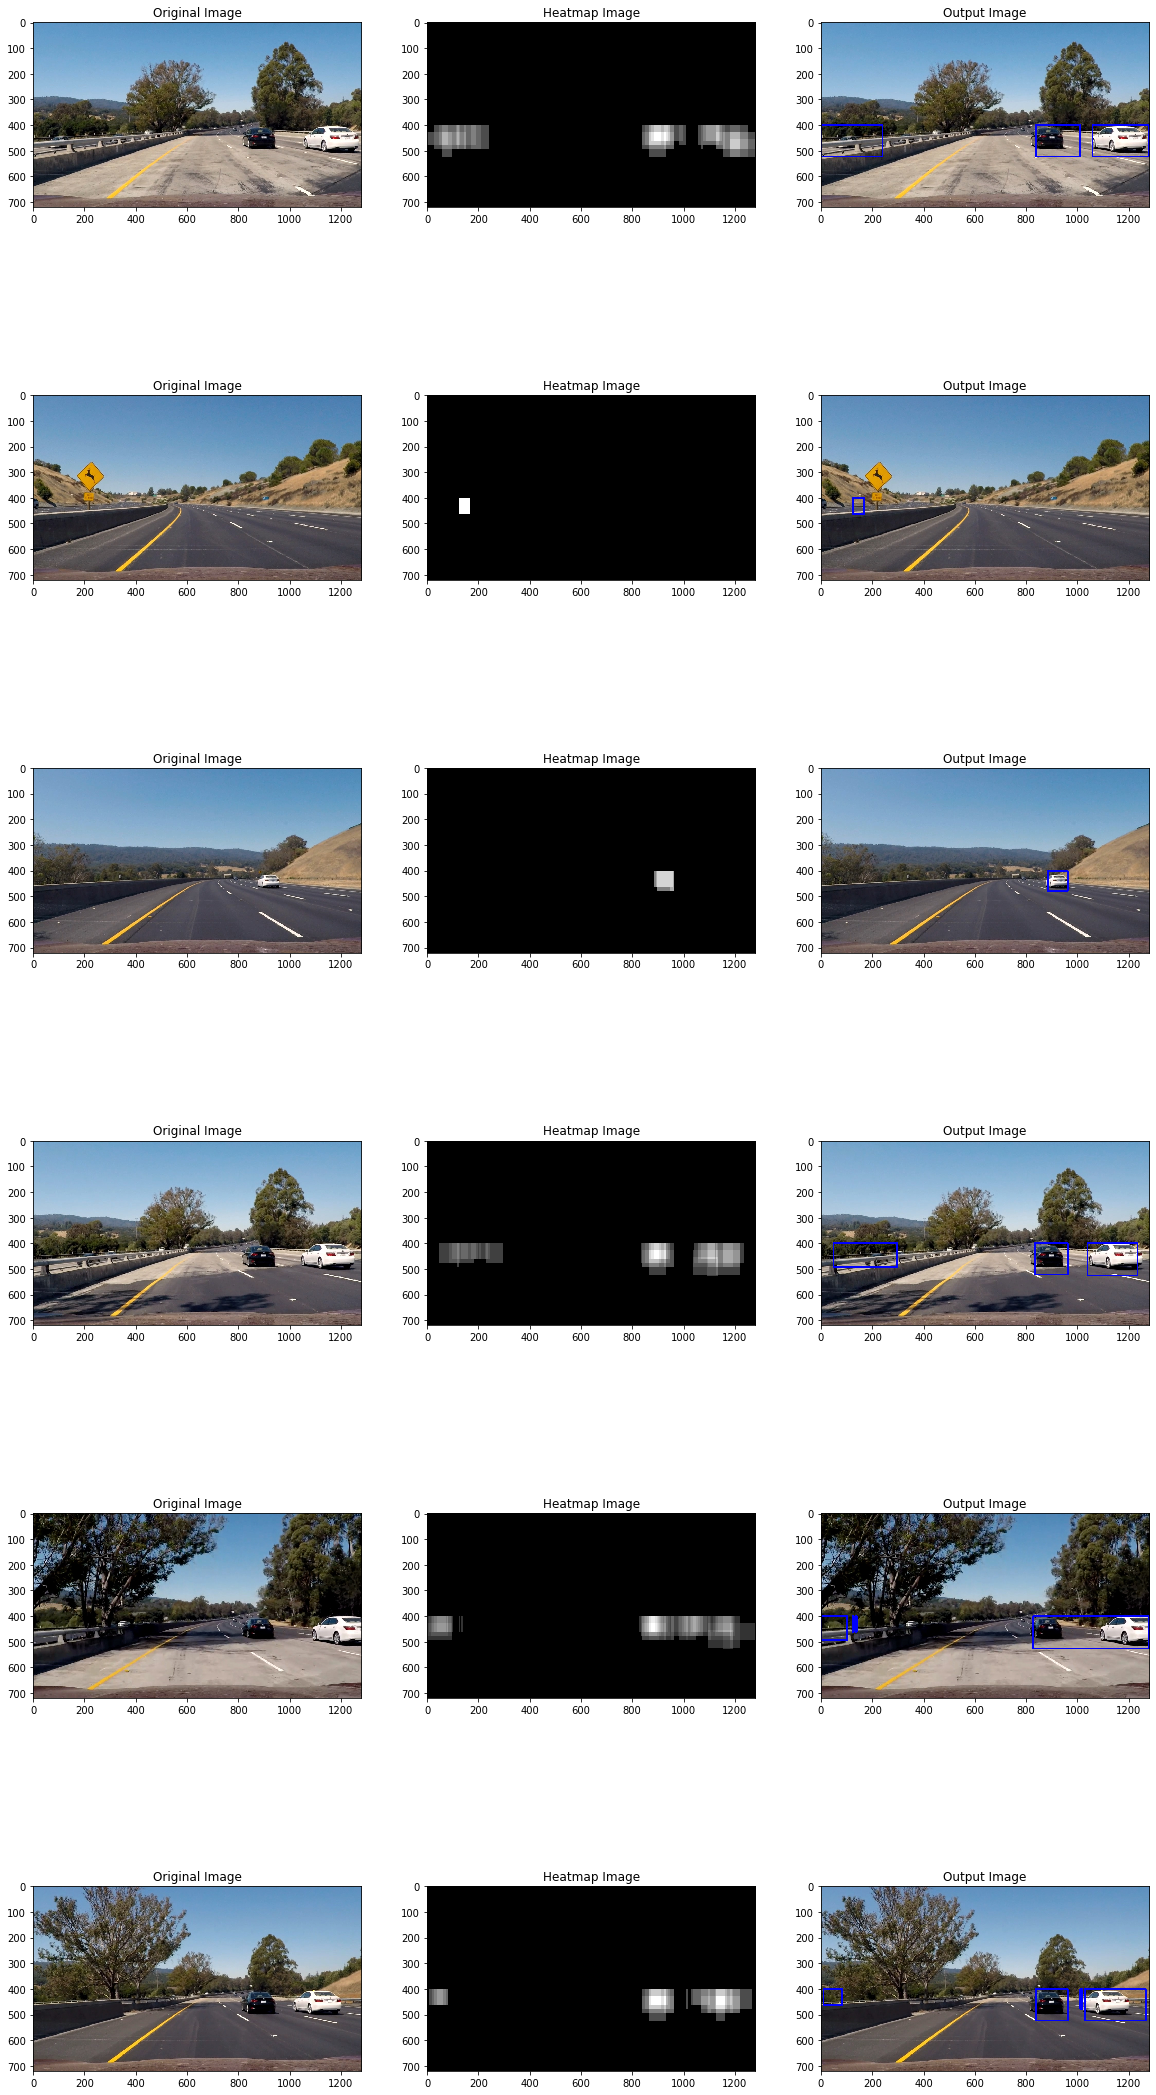

In [26]:
test_images= glob.glob("*.jpg")
f, axes= plt.subplots(6,3, figsize=(20,40))

for index,image in enumerate(test_images):
    image = cv2.imread(image)
    
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    out_img, heatmap = image_pipeline(image)
    axes[index,0].imshow(image)
    axes[index,0].set_title("Original Image")
    axes[index,1].imshow(heatmap,cmap='gray')
    axes[index,1].set_title("Heatmap Image")
    axes[index,2].imshow(out_img)
    axes[index,2].set_title("Output Image")


# Testing Pipeline on Test Video

In [27]:
averaging_windows = Averaging()
import moviepy
from moviepy.editor import VideoFileClip
video_output1 = 'Output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(video_pipeline)
%time processed_video.write_videofile(video_output1, audio=False)
video_input1.reader.close()
video_input1.audio.reader.close_proc()

"averaging_windows = Averaging()\nimport moviepy\nfrom moviepy.editor import VideoFileClip\nvideo_output1 = 'Output.mp4'\nvideo_input1 = VideoFileClip('project_video.mp4')\nprocessed_video = video_input1.fl_image(video_pipeline)\n%time processed_video.write_videofile(video_output1, audio=False)\nvideo_input1.reader.close()\nvideo_input1.audio.reader.close_proc()"

In [28]:
averaging_windows = Averaging()
import moviepy
from moviepy.editor import VideoFileClip
video_output1 = 'Output1.mp4'
video_input1 = VideoFileClip('video.mp4')
processed_video = video_input1.fl_image(video_pipeline)
%time processed_video.write_videofile(video_output1, audio=False)
video_input1.reader.close()
video_input1.audio.reader.close_proc()

Moviepy - Building video Output1.mp4.
Moviepy - Writing video Output1.mp4



Moviepy - Done !
Moviepy - video ready Output1.mp4
Wall time: 28min 45s
